In [35]:
import numpy as np
from scipy.io import loadmat
import h5py
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Data downloaded from https://janelia.figshare.com/articles/Whole-brain_light-sheet_imaging_data/7272617

In [3]:
beh_dat=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')['data']['Behavior_full'][0][0]

In [4]:
stim_dat=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')['data']['stim_full'][0][0]

In [5]:
hf = h5py.File('/media/maria/DATA1/Documents/ZebraFish/subject_1/TimeSeries.h5', 'r')
neural_dat=np.array(hf['CellResp'])

In [6]:
print(beh_dat.shape)
print(stim_dat.shape)
print(neural_dat.shape)

(5, 2880)
(1, 2880)
(2880, 83205)


In [7]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

In [50]:
itrain,itest=train_test_split(beh_dat.shape[1])
beh_train=beh_dat[:,itrain]
beh_test=beh_dat[:,itest]
stim_train=stim_dat[:,itrain].astype('float64')
stim_test=stim_dat[:,itest].astype('float64')
neural_train=neural_dat.T[:,itrain]
neural_test=neural_dat.T[:,itest]
print('Training set size: ',beh_train.shape[1])
print('Test set size: ',beh_test.shape[1])

Training set size:  2160
Test set size:  720


In [13]:
ep=EnsemblePursuit(n_components=100,lam=0.01,n_kmeans=100)
ep.fit(neural_train[:10000,:].T)

obtained 100 PCs in 1.6120 seconds
initialized 100 clusters with k-means in 3.4904 seconds
ensemble 0, time 5.51, nr neurons 3979, EV 0.0538
ensemble 25, time 39.21, nr neurons 851, EV 0.2080
ensemble 50, time 51.13, nr neurons 228, EV 0.2370
ensemble 75, time 58.97, nr neurons 41, EV 0.2530
ensemble 99, time 65.45, nr neurons 135, EV 0.2649
average sparsity is 0.0574


In [15]:
V=ep.components_
U=ep.weights

In [52]:
covM = np.matmul(beh_train, beh_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh_train.shape[0])
A = np.linalg.solve(covM, np.matmul(beh_train, V))
print(A.shape)
Vpred = np.matmul(A.T, beh_test)
beh_corr_lst=[]
V_g=U.T@neural_test[:10000,:]
print(V_g.shape)
for j in range(0,100):
    beh_corr_lst.append(np.corrcoef(Vpred[j,:],V_g[j,:])[0,1])

(5, 100)
(100, 720)


In [32]:
print(beh_corr_lst)

[0.6020590313280871, -0.2019861374897855, -0.037653568432236, 0.3074901365756037, 0.6685927224223395, 0.3399992625126928, 0.3147643650346174, -0.45378941522717686, -0.36042844522386647, 0.38165468633668775, 0.6254906840311655, -0.36415529593088836, -0.31859406387841155, 0.5177161348856129, -0.46596874185854775, 0.46158690916626416, 0.5024497224642159, -0.4507990261594522, -0.4297548932900158, -0.42362533977204586, -0.45624490950865365, 0.6472925749510761, 0.5679248630291175, -0.4498581302127292, -0.3355776209750361, 0.4624673231019018, 0.13381656242321194, 0.41038434045498856, 0.3617792919830546, -0.30566695942823485, 0.4161317042949022, -0.4434881412884115, 0.5789955189850052, -0.35626475625295156, -0.24721426600936222, -0.43435644517800615, -0.42258423919012705, 0.51753746132549, 0.6008337175343145, 0.22117219380288544, -0.383726255586805, 0.2698201744014306, 0.25074480874522453, -0.46575900608841836, 0.2869592088815962, -0.10892046548257403, 0.5029949121988546, -0.4352256464339926, 

In [51]:
covM = np.matmul(stim_train, stim_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(stim_train.shape[0])
A = np.linalg.solve(covM, np.matmul(stim_train, V))
Vpred = np.matmul(A.T, stim_test)
stim_corr_lst=[]
print(V_g.shape)
for j in range(0,100):
    stim_corr_lst.append(np.corrcoef(Vpred[j,:],V_g[j,:])[0,1])

(100, 720)


In [47]:
print(stim_corr_lst)
print(beh_corr_lst)

[0.6020590313280871, -0.2019861374897855, -0.037653568432236, 0.3074901365756037, 0.6685927224223395, 0.3399992625126928, 0.3147643650346174, -0.45378941522717686, -0.36042844522386647, 0.38165468633668775, 0.6254906840311655, -0.36415529593088836, -0.31859406387841155, 0.5177161348856129, -0.46596874185854775, 0.46158690916626416, 0.5024497224642159, -0.4507990261594522, -0.4297548932900158, -0.42362533977204586, -0.45624490950865365, 0.6472925749510761, 0.5679248630291175, -0.4498581302127292, -0.3355776209750361, 0.4624673231019018, 0.13381656242321194, 0.41038434045498856, 0.3617792919830546, -0.30566695942823485, 0.4161317042949022, -0.4434881412884115, 0.5789955189850052, -0.35626475625295156, -0.24721426600936222, -0.43435644517800615, -0.42258423919012705, 0.51753746132549, 0.6008337175343145, 0.22117219380288544, -0.383726255586805, 0.2698201744014306, 0.25074480874522453, -0.46575900608841836, 0.2869592088815962, -0.10892046548257403, 0.5029949121988546, -0.4352256464339926, 

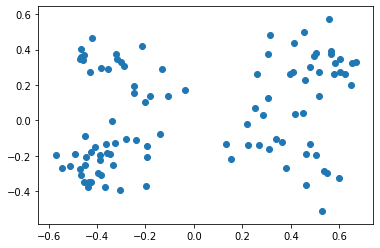

In [53]:
plt.scatter(beh_corr_lst,stim_corr_lst)
plt.xlabel()